In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime as dt
import xgboost 
import os
import pickle

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    ExtraTreesClassifier,
)
from scipy.stats import randint, uniform

## Process Weather Data

In [2]:
weather_data = pd.read_csv("../data/processed_weather_data_leuven.csv", index_col=0)


In [3]:
weather_data.head(4)

,time,temperature_2m,relativehumidity_2m,dewpoint_2m,apparent_temperature,pressure_msl,surface_pressure,precipitation,rain,snowfall,...,direct_radiation,diffuse_radiation,direct_normal_irradiance,windspeed_10m,winddirection_10m,windgusts_10m,date,hour,month,weekday
0,2022-01-01 00:00:00,12.7,92,11.5,10.9,1023.6,1020.4,0.0,0.0,0.0,...,0.0,0.0,0.0,15.3,243,30.2,2022-01-01,0,1,Sat
1,2022-01-01 01:00:00,12.7,92,11.5,11.2,1024.0,1020.8,0.0,0.0,0.0,...,0.0,0.0,0.0,13.4,243,26.6,2022-01-01,1,1,Sat
2,2022-01-01 02:00:00,12.6,93,11.4,12.0,1023.7,1020.5,0.0,0.0,0.0,...,0.0,0.0,0.0,6.9,242,27.0,2022-01-01,2,1,Sat
3,2022-01-01 03:00:00,12.5,93,11.3,11.7,1024.4,1021.2,0.0,0.0,0.0,...,0.0,0.0,0.0,7.6,239,28.4,2022-01-01,3,1,Sat


In [4]:
weather_data.columns

Index(['time', 'temperature_2m', 'relativehumidity_2m', 'dewpoint_2m',
       'apparent_temperature', 'pressure_msl', 'surface_pressure',
       'precipitation', 'rain', 'snowfall', 'weathercode', 'cloudcover',
       'cloudcover_low', 'cloudcover_mid', 'cloudcover_high',
       'shortwave_radiation', 'direct_radiation', 'diffuse_radiation',
       'direct_normal_irradiance', 'windspeed_10m', 'winddirection_10m',
       'windgusts_10m', 'date', 'hour', 'month', 'weekday'],
      dtype='object')

In [5]:
weather_data.dtypes

time                         object
temperature_2m              float64
relativehumidity_2m           int64
dewpoint_2m                 float64
apparent_temperature        float64
pressure_msl                float64
surface_pressure            float64
precipitation               float64
rain                        float64
snowfall                    float64
weathercode                   int64
cloudcover                    int64
cloudcover_low                int64
cloudcover_mid                int64
cloudcover_high               int64
shortwave_radiation         float64
direct_radiation            float64
diffuse_radiation           float64
direct_normal_irradiance    float64
windspeed_10m               float64
winddirection_10m             int64
windgusts_10m               float64
date                         object
hour                          int64
month                         int64
weekday                      object
dtype: object

In [6]:
np.unique(weather_data.weathercode)

array([ 0,  1,  2,  3, 51, 53, 55, 61, 63, 65, 71, 73], dtype=int64)

In [7]:
# extract from timestamp
weather_data["time"] = pd.to_datetime(weather_data["time"])
weather_data["date"] = weather_data["time"].dt.date
weather_data["hour"] = weather_data["time"].dt.hour
weather_data["month"] = weather_data["time"].dt.month
weather_data["weekday"] = weather_data["time"].dt.strftime("%a")
weather_data.head(5)

,time,temperature_2m,relativehumidity_2m,dewpoint_2m,apparent_temperature,pressure_msl,surface_pressure,precipitation,rain,snowfall,...,direct_radiation,diffuse_radiation,direct_normal_irradiance,windspeed_10m,winddirection_10m,windgusts_10m,date,hour,month,weekday
0,2022-01-01 00:00:00,12.7,92,11.5,10.9,1023.6,1020.4,0.0,0.0,0.0,...,0.0,0.0,0.0,15.3,243,30.2,2022-01-01,0,1,Sat
1,2022-01-01 01:00:00,12.7,92,11.5,11.2,1024.0,1020.8,0.0,0.0,0.0,...,0.0,0.0,0.0,13.4,243,26.6,2022-01-01,1,1,Sat
2,2022-01-01 02:00:00,12.6,93,11.4,12.0,1023.7,1020.5,0.0,0.0,0.0,...,0.0,0.0,0.0,6.9,242,27.0,2022-01-01,2,1,Sat
3,2022-01-01 03:00:00,12.5,93,11.3,11.7,1024.4,1021.2,0.0,0.0,0.0,...,0.0,0.0,0.0,7.6,239,28.4,2022-01-01,3,1,Sat
4,2022-01-01 04:00:00,12.3,93,11.2,11.7,1024.3,1021.1,0.0,0.0,0.0,...,0.0,0.0,0.0,6.4,232,26.6,2022-01-01,4,1,Sat


In [8]:
weather_data.drop("time", axis=1, inplace=True)

In [9]:
weather_data.shape

(8760, 25)

In [10]:
weather_data.head(3)

,temperature_2m,relativehumidity_2m,dewpoint_2m,apparent_temperature,pressure_msl,surface_pressure,precipitation,rain,snowfall,weathercode,...,direct_radiation,diffuse_radiation,direct_normal_irradiance,windspeed_10m,winddirection_10m,windgusts_10m,date,hour,month,weekday
0,12.7,92,11.5,10.9,1023.6,1020.4,0.0,0.0,0.0,3,...,0.0,0.0,0.0,15.3,243,30.2,2022-01-01,0,1,Sat
1,12.7,92,11.5,11.2,1024.0,1020.8,0.0,0.0,0.0,3,...,0.0,0.0,0.0,13.4,243,26.6,2022-01-01,1,1,Sat
2,12.6,93,11.4,12.0,1023.7,1020.5,0.0,0.0,0.0,3,...,0.0,0.0,0.0,6.9,242,27.0,2022-01-01,2,1,Sat


## Process air quality data

In [11]:
air_quality_data = pd.read_csv("../data/processed_air_quality_data.csv", index_col=0)


In [12]:
air_quality_data.head(3)

,dt,pm2_5,pm10,co,no2,o3,so2,nh3,date,hour,month,weekday
0,2022-01-01 01:00:00,3.68,5.20,253.68,8.83,39.34,1.82,0.79,2022-01-01,1,1,Sat
1,2022-01-01 02:00:00,3.69,5.27,250.34,8.05,38.62,1.86,0.79,2022-01-01,2,1,Sat
2,2022-01-01 03:00:00,3.44,4.99,247.00,7.11,38.27,1.71,0.78,2022-01-01,3,1,Sat


In [13]:
air_quality_data.columns

Index(['dt', 'pm2_5', 'pm10', 'co', 'no2', 'o3', 'so2', 'nh3', 'date', 'hour',
       'month', 'weekday'],
      dtype='object')

In [14]:
# extract from timestamp
air_quality_data["date"] = pd.to_datetime(air_quality_data["date"]).dt.date
air_quality_data.head(5)



,dt,pm2_5,pm10,co,no2,o3,so2,nh3,date,hour,month,weekday
0,2022-01-01 01:00:00,3.68,5.20,253.68,8.83,39.34,1.82,0.79,2022-01-01,1,1,Sat
1,2022-01-01 02:00:00,3.69,5.27,250.34,8.05,38.62,1.86,0.79,2022-01-01,2,1,Sat
2,2022-01-01 03:00:00,3.44,4.99,247.00,7.11,38.27,1.71,0.78,2022-01-01,3,1,Sat
3,2022-01-01 04:00:00,2.93,4.26,243.66,6.17,38.62,1.33,0.72,2022-01-01,4,1,Sat
4,2022-01-01 05:00:00,3.02,4.07,257.02,6.85,37.19,1.03,0.68,2022-01-01,5,1,Sat


In [15]:
air_quality_data = (
    air_quality_data.groupby(["date", "hour", "month", "weekday"]).mean().reset_index()
)

C:\Users\jef-w\AppData\Local\Temp\ipykernel_3008\3314303586.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  air_quality_data.groupby(["date", "hour", "month", "weekday"]).mean().reset_index()


In [16]:
air_quality_data

,date,hour,month,weekday,pm2_5,pm10,co,no2,o3,so2,nh3
0,2022-01-01,1,1,Sat,3.68,5.20,253.68,8.83,39.34,1.82,0.79
1,2022-01-01,2,1,Sat,3.69,5.27,250.34,8.05,38.62,1.86,0.79
2,2022-01-01,3,1,Sat,3.44,4.99,247.00,7.11,38.27,1.71,0.78
3,2022-01-01,4,1,Sat,2.93,4.26,243.66,6.17,38.62,1.33,0.72
4,2022-01-01,5,1,Sat,3.02,4.07,257.02,6.85,37.19,1.03,0.68
...,...,...,...,...,...,...,...,...,...,...,...
8587,2022-12-31,21,12,Sat,4.05,5.78,220.30,6.00,61.51,1.12,1.41
8588,2022-12-31,22,12,Sat,4.12,6.10,216.96,5.31,62.94,1.03,1.36
8589,2022-12-31,23,12,Sat,4.19,6.58,213.62,4.58,65.09,0.92,1.31
8590,2023-01-01,0,1,Sun,4.28,7.12,210.29,3.73,67.23,0.81,1.30


## Process file42 data

In [17]:
file42 = pd.read_csv("../data/processed_file42_data.csv", index_col=0)
file42.dropna(inplace=True)
file42.head(5)

,result_timestamp,#object_id,lamax,laeq,lceq,lcpeak,hour,weekday,month,location
8203,2022-02-28 08:00:00,255439.0,58.679893,56.965367,67.359289,78.976896,8,Mon,2,MP 01: Naamsestraat 35 Maxim
8208,2022-02-28 13:00:00,255439.0,57.610063,55.556352,64.805270,76.718642,13,Mon,2,MP 01: Naamsestraat 35 Maxim
8209,2022-02-28 14:00:00,255439.0,57.101721,55.100833,64.435944,76.297757,14,Mon,2,MP 01: Naamsestraat 35 Maxim
8210,2022-02-28 15:00:00,255439.0,56.258222,54.167056,62.930547,75.222819,15,Mon,2,MP 01: Naamsestraat 35 Maxim
8211,2022-02-28 16:00:00,255439.0,57.101444,54.979111,63.220742,75.562858,16,Mon,2,MP 01: Naamsestraat 35 Maxim


In [18]:
file42.columns

Index(['result_timestamp', '#object_id', 'lamax', 'laeq', 'lceq', 'lcpeak',
       'hour', 'weekday', 'month', 'location'],
      dtype='object')

In [19]:
file42.rename(columns={"#object_id": "object_id"}, inplace=True)

In [20]:
file42["object_id"] = pd.to_numeric(file42["object_id"]).astype(int)

In [21]:
file42.head(5)

,result_timestamp,object_id,lamax,laeq,lceq,lcpeak,hour,weekday,month,location
8203,2022-02-28 08:00:00,255439,58.679893,56.965367,67.359289,78.976896,8,Mon,2,MP 01: Naamsestraat 35 Maxim
8208,2022-02-28 13:00:00,255439,57.610063,55.556352,64.805270,76.718642,13,Mon,2,MP 01: Naamsestraat 35 Maxim
8209,2022-02-28 14:00:00,255439,57.101721,55.100833,64.435944,76.297757,14,Mon,2,MP 01: Naamsestraat 35 Maxim
8210,2022-02-28 15:00:00,255439,56.258222,54.167056,62.930547,75.222819,15,Mon,2,MP 01: Naamsestraat 35 Maxim
8211,2022-02-28 16:00:00,255439,57.101444,54.979111,63.220742,75.562858,16,Mon,2,MP 01: Naamsestraat 35 Maxim


In [22]:
# Convert the 'result_timestamp' column to a datetime data type
file42["result_timestamp"] = pd.to_datetime(file42["result_timestamp"])
file42["date"] = file42["result_timestamp"].dt.date
file42["hour"] = file42["result_timestamp"].dt.hour
file42["month"] = file42["result_timestamp"].dt.month
file42["weekday"] = file42["result_timestamp"].dt.strftime("%a")
file42.head(4)

,result_timestamp,object_id,lamax,laeq,lceq,lcpeak,hour,weekday,month,location,date
8203,2022-02-28 08:00:00,255439,58.679893,56.965367,67.359289,78.976896,8,Mon,2,MP 01: Naamsestraat 35 Maxim,2022-02-28
8208,2022-02-28 13:00:00,255439,57.610063,55.556352,64.805270,76.718642,13,Mon,2,MP 01: Naamsestraat 35 Maxim,2022-02-28
8209,2022-02-28 14:00:00,255439,57.101721,55.100833,64.435944,76.297757,14,Mon,2,MP 01: Naamsestraat 35 Maxim,2022-02-28
8210,2022-02-28 15:00:00,255439,56.258222,54.167056,62.930547,75.222819,15,Mon,2,MP 01: Naamsestraat 35 Maxim,2022-02-28


In [23]:
file42 = (
    file42.groupby(["object_id", "date", "hour", "month", "weekday"])
    .mean()
    .reset_index()
)
file42.head(5)

C:\Users\jef-w\AppData\Local\Temp\ipykernel_3008\1536898315.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  .mean()


,object_id,date,hour,month,weekday,lamax,laeq,lceq,lcpeak
0,255439,2022-02-28,8,2,Mon,58.679893,56.965367,67.359289,78.976896
1,255439,2022-02-28,13,2,Mon,57.610063,55.556352,64.805270,76.718642
2,255439,2022-02-28,14,2,Mon,57.101721,55.100833,64.435944,76.297757
3,255439,2022-02-28,15,2,Mon,56.258222,54.167056,62.930547,75.222819
4,255439,2022-02-28,16,2,Mon,57.101444,54.979111,63.220742,75.562858


## Merge data

In [24]:
data_model = file42.merge(
    air_quality_data,
    how="inner",
    left_on=["date", "hour", "month", "weekday"],
    right_on=["date", "hour", "month", "weekday"],
)

In [25]:
data_model = data_model.merge(
    weather_data,
    how="inner",
    left_on=["date", "hour", "month", "weekday"],
    right_on=["date", "hour", "month", "weekday"],
)

In [26]:
data_model.shape

(54413, 37)

In [27]:
data_model.head(5)

,object_id,date,hour,month,weekday,lamax,laeq,lceq,lcpeak,pm2_5,...,cloudcover_low,cloudcover_mid,cloudcover_high,shortwave_radiation,direct_radiation,diffuse_radiation,direct_normal_irradiance,windspeed_10m,winddirection_10m,windgusts_10m
0,255439,2022-02-28,8,2,Mon,58.679893,56.965367,67.359289,78.976896,9.27,...,0,0,0,0.0,0.0,0.0,0.0,11.9,295,16.2
1,255441,2022-02-28,8,2,Mon,55.492778,54.066667,65.229694,76.438689,9.27,...,0,0,0,0.0,0.0,0.0,0.0,11.9,295,16.2
2,255442,2022-02-28,8,2,Mon,55.842472,54.106667,63.679853,75.430328,9.27,...,0,0,0,0.0,0.0,0.0,0.0,11.9,295,16.2
3,255443,2022-02-28,8,2,Mon,55.250278,53.569000,63.015794,74.931089,9.27,...,0,0,0,0.0,0.0,0.0,0.0,11.9,295,16.2
4,255444,2022-02-28,8,2,Mon,55.992611,54.480028,64.411319,75.940522,9.27,...,0,0,0,0.0,0.0,0.0,0.0,11.9,295,16.2


In [28]:
data_model.dtypes

object_id                     int64
date                         object
hour                          int64
month                         int64
weekday                      object
lamax                       float64
laeq                        float64
lceq                        float64
lcpeak                      float64
pm2_5                       float64
pm10                        float64
co                          float64
no2                         float64
o3                          float64
so2                         float64
nh3                         float64
temperature_2m              float64
relativehumidity_2m           int64
dewpoint_2m                 float64
apparent_temperature        float64
pressure_msl                float64
surface_pressure            float64
precipitation               float64
rain                        float64
snowfall                    float64
weathercode                   int64
cloudcover                    int64
cloudcover_low              

In [29]:
## split train, test data
train_df, val_df = train_test_split(data_model, test_size=0.2, random_state=7)

## Process dependent variables

In [30]:
target_variable = ["lamax", "laeq", "lceq", "lcpeak"]

In [31]:
y_train = train_df[target_variable]
y_train.head(2)

,lamax,laeq,lceq,lcpeak
46575,57.524278,55.794722,63.272894,75.597211
26968,48.282722,46.791806,57.034947,68.439956


In [32]:
y_val = val_df[target_variable]
y_val.head(2)

,lamax,laeq,lceq,lcpeak
38808,42.591306,40.860722,49.396692,62.092933
43213,55.326611,53.388611,61.123072,73.719969


## Process independent variables

In [33]:
X_train = train_df.drop(target_variable + ["date"], axis=1)
X_val = val_df.drop(target_variable + ["date"], axis=1)

In [34]:
X_train.columns

Index(['object_id', 'hour', 'month', 'weekday', 'pm2_5', 'pm10', 'co', 'no2',
       'o3', 'so2', 'nh3', 'temperature_2m', 'relativehumidity_2m',
       'dewpoint_2m', 'apparent_temperature', 'pressure_msl',
       'surface_pressure', 'precipitation', 'rain', 'snowfall', 'weathercode',
       'cloudcover', 'cloudcover_low', 'cloudcover_mid', 'cloudcover_high',
       'shortwave_radiation', 'direct_radiation', 'diffuse_radiation',
       'direct_normal_irradiance', 'windspeed_10m', 'winddirection_10m',
       'windgusts_10m'],
      dtype='object')

In [35]:
one_hot_var = ["hour", "month", "weekday", "object_id", "weathercode"]
numerical_var = [col for col in X_train.columns if col not in one_hot_var]

In [36]:
t = ColumnTransformer(
    transformers=[
        ("OneHot", OneHotEncoder(handle_unknown="ignore"), one_hot_var),
        ("StandardScaler", StandardScaler(), numerical_var),
    ]
)

# fit the encoder
t.fit(X_train)

ColumnTransformer(transformers=[('OneHot',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['hour', 'month', 'weekday', 'object_id',
                                  'weathercode']),
                                ('StandardScaler', StandardScaler(),
                                 ['pm2_5', 'pm10', 'co', 'no2', 'o3', 'so2',
                                  'nh3', 'temperature_2m',
                                  'relativehumidity_2m', 'dewpoint_2m',
                                  'apparent_temperature', 'pressure_msl',
                                  'surface_pressure', 'precipitation', 'rain',
                                  'snowfall', 'cloudcover', 'cloudcover_low',
                                  'cloudcover_mid', 'cloudcover_high',
                                  'shortwave_radiation', 'direct_radiation',
                                  'diffuse_radiation',
                                  'direct_normal_irradiance', 'windspeed_10m',
                                  'winddirection_10m', 'windgusts_10m'])])

In [37]:
## save columnstransformer

with open("../model/model_noise_level_file42/encoder_model_file42.pkl", "wb") as file:
    pickle.dump(t, file)

In [38]:
# Load the pickle file
with open("../model/model_noise_level_file42/encoder_model_file42.pkl", "rb") as file:
    t = pickle.load(file)

In [39]:
# create pandas DataFrame from dense matrix
X_train = pd.DataFrame(t.fit_transform(X_train), columns=t.get_feature_names_out())

X_val = pd.DataFrame(t.transform(X_val), columns=t.get_feature_names_out())

In [40]:
X_train.columns

Index(['OneHot__hour_0', 'OneHot__hour_1', 'OneHot__hour_2', 'OneHot__hour_3',
       'OneHot__hour_4', 'OneHot__hour_5', 'OneHot__hour_6', 'OneHot__hour_7',
       'OneHot__hour_8', 'OneHot__hour_9', 'OneHot__hour_10',
       'OneHot__hour_11', 'OneHot__hour_12', 'OneHot__hour_13',
       'OneHot__hour_14', 'OneHot__hour_15', 'OneHot__hour_16',
       'OneHot__hour_17', 'OneHot__hour_18', 'OneHot__hour_19',
       'OneHot__hour_20', 'OneHot__hour_21', 'OneHot__hour_22',
       'OneHot__hour_23', 'OneHot__month_1', 'OneHot__month_2',
       'OneHot__month_3', 'OneHot__month_4', 'OneHot__month_5',
       'OneHot__month_6', 'OneHot__month_7', 'OneHot__month_8',
       'OneHot__month_9', 'OneHot__month_10', 'OneHot__month_11',
       'OneHot__month_12', 'OneHot__weekday_Fri', 'OneHot__weekday_Mon',
       'OneHot__weekday_Sat', 'OneHot__weekday_Sun', 'OneHot__weekday_Thu',
       'OneHot__weekday_Tue', 'OneHot__weekday_Wed',
       'OneHot__object_id_255439', 'OneHot__object_id_255440',
 

In [41]:
y_train.columns

Index(['lamax', 'laeq', 'lceq', 'lcpeak'], dtype='object')

## Predict lamax

In [42]:
# Define the model parameters
model_params = {
    "random_forest": {
        "model": RandomForestRegressor(),
        "params": {
            "n_estimators": randint(50, 100),
            "max_depth": randint(3, 50),
            "max_features": ["auto", "sqrt"],
            "min_samples_split": randint(2, 20),
            "min_samples_leaf": randint(1, 10),
            "bootstrap": [True, False],
        },
    },
    "gradient_boosting": {
        "model": GradientBoostingRegressor(),
        "params": {
            "n_estimators": randint(50, 100),
            "learning_rate": uniform(0.01, 0.5),
            "max_depth": randint(1, 10),
            "min_samples_split": randint(2, 20),
            "min_samples_leaf": randint(1, 10),
        },
    },
    "xgboost": {
        "model": xgboost.XGBRegressor(),
        "params": {
            "n_estimators": randint(50, 100),
            "learning_rate": uniform(0.01, 0.5),
            "max_depth": randint(1, 10),
            "min_child_weight": randint(1, 10),
            "gamma": uniform(0, 1),
            "reg_alpha": uniform(0, 1),
            "reg_lambda": uniform(0, 1),
        },
    },
}

params_dict = {}

# Loop through each model in model_params and run RandomizedSearchCV
for model_name, model_info in model_params.items():
    print("Running RandomizedSearchCV for {}...".format(model_name))

    # Create a RandomizedSearchCV object for the current model
    model = model_info["model"]
    param_dist = model_info["params"]
    random_search = RandomizedSearchCV(
        model, param_distributions=param_dist, n_iter=10, cv=5, n_jobs=1, random_state=7
    )

    # Fit the RandomizedSearchCV object to the data
    random_search.fit(X_train, y_train["lamax"])

    # Print the best parameters and score
    params_dict[model_name] = random_search.best_params_
    print("Best parameters for {}: ".format(model_name), random_search.best_params_)
    print("Best score for {}: ".format(model_name), random_search.best_score_)
    print("\n")


Running RandomizedSearchCV for random_forest...


C:\Users\jef-w\anaconda3\envs\MDAproject\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\jef-w\anaconda3\envs\MDAproject\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


KeyboardInterrupt: 

In [ ]:
# Save optimal param dictionary
pickle.dump(params_dict, open("../model/model_noise_level_file42/lamax_dict", "wb"))

In [43]:
# Load param dictionary
lamax_dict = pickle.load(open("../model/model_noise_level_file42/lamax_dict", "rb"))
lamax_dict

{'random_forest': {'bootstrap': False,
  'max_depth': 31,
  'max_features': 'sqrt',
  'min_samples_leaf': 1,
  'min_samples_split': 6,
  'n_estimators': 85},
 'gradient_boosting': {'learning_rate': 0.4289589971546303,
  'max_depth': 8,
  'min_samples_leaf': 8,
  'min_samples_split': 2,
  'n_estimators': 71},
 'xgboost': {'gamma': 0.13316944575925016,
  'learning_rate': 0.2717062903368829,
  'max_depth': 9,
  'min_child_weight': 4,
  'n_estimators': 98,
  'reg_alpha': 0.19335562339240953,
  'reg_lambda': 0.100473971701034}}

In [44]:
gb_params = lamax_dict["gradient_boosting"]

gb = GradientBoostingRegressor(**gb_params, random_state=7)

gb.fit(X_train, y_train["lamax"])

train_preds = gb.predict(X_train)
val_preds = gb.predict(X_val)

print("Train RMSE:", np.sqrt(mean_squared_error(train_preds, y_train["lamax"])))
print("Val RMSE:", np.sqrt(mean_squared_error(val_preds, y_val["lamax"])))
print("Train MAE:", mean_absolute_error(train_preds, y_train["lamax"]))
print("Val MAE:", mean_absolute_error(val_preds, y_val["lamax"]))

Train RMSE: 1.4280491175931176
Val RMSE: 2.0558287405869047
Train MAE: 0.9946501592697466
Val MAE: 1.3868413148756473


In [45]:
rf_params = lamax_dict["random_forest"]

rf = RandomForestRegressor(**rf_params, random_state=7)

rf.fit(X_train, y_train["lamax"])

train_preds = rf.predict(X_train)
val_preds = rf.predict(X_val)

print("Train RMSE:", np.sqrt(mean_squared_error(train_preds, y_train["lamax"])))
print("Val RMSE:", np.sqrt(mean_squared_error(val_preds, y_val["lamax"])))
print("Train MAE:", mean_absolute_error(train_preds, y_train["lamax"]))
print("Val MAE:", mean_absolute_error(val_preds, y_val["lamax"]))

Train RMSE: 1.1060793551980486
Val RMSE: 2.1701450325435836
Train MAE: 0.7494223128531653
Val MAE: 1.4579371305789268


In [46]:
xgb_params = lamax_dict["xgboost"]

xgb = xgboost.XGBRegressor(**xgb_params, random_state=7)

xgb.fit(X_train, y_train["lamax"])

train_preds = xgb.predict(X_train)
val_preds = xgb.predict(X_val)


print("Train RMSE:", np.sqrt(mean_squared_error(train_preds, y_train["lamax"])))
print("Val RMSE:", np.sqrt(mean_squared_error(val_preds, y_val["lamax"])))
print("Train MAE:", mean_absolute_error(train_preds, y_train["lamax"]))
print("Val MAE:", mean_absolute_error(val_preds, y_val["lamax"]))


Train RMSE: 1.0863792982579672
Val RMSE: 1.886690541616359
Train MAE: 0.7641576094868555
Val MAE: 1.2553625466133227


Text(0, 0.5, 'y val')

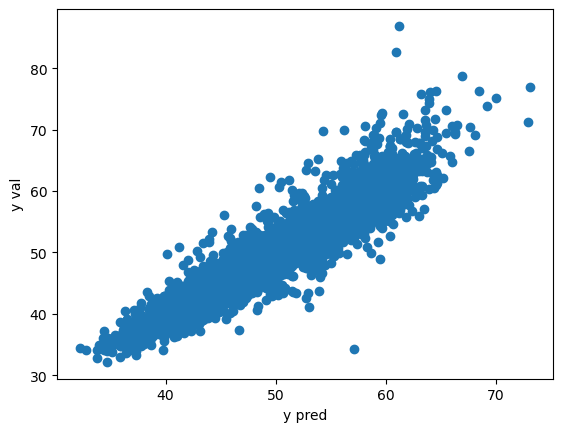

In [47]:
plt.scatter(val_preds, y_val["lamax"])
plt.xlabel("y pred")
plt.ylabel("y val")

In [48]:
r2_score(val_preds, y_val["lamax"])

0.8969124218987571

In [49]:
## save model

pickle.dump(xgb, open("../model/model_noise_level_file42/xgb_lamax.pkl", "wb"))

## predict laeq

In [ ]:
# Define the model parameters
model_params = {
    "random_forest": {
        "model": RandomForestRegressor(),
        "params": {
            "n_estimators": randint(50, 100),
            "max_depth": randint(3, 50),
            "max_features": ["auto", "sqrt"],
            "min_samples_split": randint(2, 20),
            "min_samples_leaf": randint(1, 10),
            "bootstrap": [True, False],
        },
    },
    "gradient_boosting": {
        "model": GradientBoostingRegressor(),
        "params": {
            "n_estimators": randint(50, 100),
            "learning_rate": uniform(0.01, 0.5),
            "max_depth": randint(1, 10),
            "min_samples_split": randint(2, 20),
            "min_samples_leaf": randint(1, 10),
        },
    },
    "xgboost": {
        "model": xgboost.XGBRegressor(),
        "params": {
            "n_estimators": randint(50, 100),
            "learning_rate": uniform(0.01, 0.5),
            "max_depth": randint(1, 10),
            "min_child_weight": randint(1, 10),
            "gamma": uniform(0, 1),
            "reg_alpha": uniform(0, 1),
            "reg_lambda": uniform(0, 1),
        },
    },
}

params_dict = {}

# Loop through each model in model_params and run RandomizedSearchCV
for model_name, model_info in model_params.items():
    print("Running RandomizedSearchCV for {}...".format(model_name))

    # Create a RandomizedSearchCV object for the current model
    model = model_info["model"]
    param_dist = model_info["params"]
    random_search = RandomizedSearchCV(
        model, param_distributions=param_dist, n_iter=10, cv=5, n_jobs=1, random_state=7
    )

    # Fit the RandomizedSearchCV object to the data
    random_search.fit(X_train, y_train["laeq"])

    # Print the best parameters and score
    params_dict[model_name] = random_search.best_params_
    print("Best parameters for {}: ".format(model_name), random_search.best_params_)
    print("Best score for {}: ".format(model_name), random_search.best_score_)
    print("\n")

In [ ]:
# Save optimal param dictionary
pickle.dump(params_dict, open("../model/model_noise_level_file42/laeq_dict", "wb"))

In [50]:
# Load param dictionary
laeq_dict = pickle.load(open("../model/model_noise_level_file42/laeq_dict", "rb"))
laeq_dict

{'random_forest': {'bootstrap': False,
  'max_depth': 31,
  'max_features': 'sqrt',
  'min_samples_leaf': 1,
  'min_samples_split': 6,
  'n_estimators': 85},
 'gradient_boosting': {'learning_rate': 0.4289589971546303,
  'max_depth': 8,
  'min_samples_leaf': 8,
  'min_samples_split': 2,
  'n_estimators': 71},
 'xgboost': {'gamma': 0.13316944575925016,
  'learning_rate': 0.2717062903368829,
  'max_depth': 9,
  'min_child_weight': 4,
  'n_estimators': 98,
  'reg_alpha': 0.19335562339240953,
  'reg_lambda': 0.100473971701034}}

In [51]:
gb_params = laeq_dict["gradient_boosting"]

gb = GradientBoostingRegressor(**gb_params, random_state=7)

gb.fit(X_train, y_train["laeq"])

train_preds = gb.predict(X_train)
val_preds = gb.predict(X_val)

print("Train RMSE:", np.sqrt(mean_squared_error(train_preds, y_train["laeq"])))
print("Val RMSE:", np.sqrt(mean_squared_error(val_preds, y_val["laeq"])))
print("Train MAE:", mean_absolute_error(train_preds, y_train["laeq"]))
print("Val MAE:", mean_absolute_error(val_preds, y_val["laeq"]))

Train RMSE: 1.3860544865109772
Val RMSE: 1.9692336080248678
Train MAE: 0.9634441016867777
Val MAE: 1.3181415030977257


In [52]:
rf_params = laeq_dict["random_forest"]

rf = RandomForestRegressor(**rf_params, random_state=7)

rf.fit(X_train, y_train["laeq"])

train_preds = rf.predict(X_train)
val_preds = rf.predict(X_val)

print("Train RMSE:", np.sqrt(mean_squared_error(train_preds, y_train["laeq"])))
print("Val RMSE:", np.sqrt(mean_squared_error(val_preds, y_val["laeq"])))
print("Train MAE:", mean_absolute_error(train_preds, y_train["laeq"]))
print("Val MAE:", mean_absolute_error(val_preds, y_val["laeq"]))

Train RMSE: 1.1340639712180036
Val RMSE: 2.1168609957626274
Train MAE: 0.7620164896489463
Val MAE: 1.4116757720212505


In [53]:
xgb_params = laeq_dict["xgboost"]

xgb = xgboost.XGBRegressor(**xgb_params, random_state=7)

xgb.fit(X_train, y_train["laeq"])

train_preds = xgb.predict(X_train)
val_preds = xgb.predict(X_val)


print("Train RMSE:", np.sqrt(mean_squared_error(train_preds, y_train["laeq"])))
print("Val RMSE:", np.sqrt(mean_squared_error(val_preds, y_val["laeq"])))
print("Train MAE:", mean_absolute_error(train_preds, y_train["laeq"]))
print("Val MAE:", mean_absolute_error(val_preds, y_val["laeq"]))

Train RMSE: 1.0701140482001519
Val RMSE: 1.8562799671440349
Train MAE: 0.7490728715992959
Val MAE: 1.2284371817352249


Text(0, 0.5, 'y val')

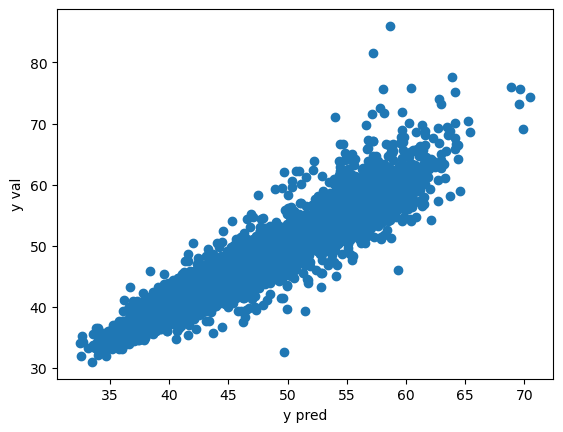

In [54]:
plt.scatter(val_preds, y_val["laeq"])
plt.xlabel("y pred")
plt.ylabel("y val")

In [55]:
r2_score(val_preds, y_val["laeq"])

0.8999985346992687

In [56]:
## save model

pickle.dump(xgb, open("../model/model_noise_level_file42/xgb_laeq.pkl", "wb"))

## Predict lceq

In [ ]:
# Define the model parameters
model_params = {
    "random_forest": {
        "model": RandomForestRegressor(),
        "params": {
            "n_estimators": randint(50, 100),
            "max_depth": randint(3, 50),
            "max_features": ["auto", "sqrt"],
            "min_samples_split": randint(2, 20),
            "min_samples_leaf": randint(1, 10),
            "bootstrap": [True, False],
        },
    },
    "gradient_boosting": {
        "model": GradientBoostingRegressor(),
        "params": {
            "n_estimators": randint(50, 100),
            "learning_rate": uniform(0.01, 0.5),
            "max_depth": randint(1, 10),
            "min_samples_split": randint(2, 20),
            "min_samples_leaf": randint(1, 10),
        },
    },
    "xgboost": {
        "model": xgboost.XGBRegressor(),
        "params": {
            "n_estimators": randint(50, 100),
            "learning_rate": uniform(0.01, 0.5),
            "max_depth": randint(1, 10),
            "min_child_weight": randint(1, 10),
            "gamma": uniform(0, 1),
            "reg_alpha": uniform(0, 1),
            "reg_lambda": uniform(0, 1),
        },
    },
}

params_dict = {}

# Loop through each model in model_params and run RandomizedSearchCV
for model_name, model_info in model_params.items():
    print("Running RandomizedSearchCV for {}...".format(model_name))

    # Create a RandomizedSearchCV object for the current model
    model = model_info["model"]
    param_dist = model_info["params"]
    random_search = RandomizedSearchCV(
        model, param_distributions=param_dist, n_iter=10, cv=5, n_jobs=1, random_state=7
    )

    # Fit the RandomizedSearchCV object to the data
    random_search.fit(X_train, y_train["lceq"])

    # Print the best parameters and score
    params_dict[model_name] = random_search.best_params_
    print("Best parameters for {}: ".format(model_name), random_search.best_params_)
    print("Best score for {}: ".format(model_name), random_search.best_score_)
    print("\n")

In [ ]:
# Save optimal param dictionary
pickle.dump(params_dict, open("../model/model_noise_level_file42/lceq_dict", "wb"))

In [57]:
# Load param dictionary
lceq_dict = pickle.load(open("../model/model_noise_level_file42/lceq_dict", "rb"))
lceq_dict

{'random_forest': {'bootstrap': False,
  'max_depth': 31,
  'max_features': 'sqrt',
  'min_samples_leaf': 1,
  'min_samples_split': 6,
  'n_estimators': 85},
 'gradient_boosting': {'learning_rate': 0.4289589971546303,
  'max_depth': 8,
  'min_samples_leaf': 8,
  'min_samples_split': 2,
  'n_estimators': 71},
 'xgboost': {'gamma': 0.13316944575925016,
  'learning_rate': 0.2717062903368829,
  'max_depth': 9,
  'min_child_weight': 4,
  'n_estimators': 98,
  'reg_alpha': 0.19335562339240953,
  'reg_lambda': 0.100473971701034}}

In [58]:
gb_params = lceq_dict["gradient_boosting"]

gb = GradientBoostingRegressor(**gb_params, random_state=7)

gb.fit(X_train, y_train["lceq"])

train_preds = gb.predict(X_train)
val_preds = gb.predict(X_val)

print("Train RMSE:", np.sqrt(mean_squared_error(train_preds, y_train["lceq"])))
print("Val RMSE:", np.sqrt(mean_squared_error(val_preds, y_val["lceq"])))
print("Train MAE:", mean_absolute_error(train_preds, y_train["lceq"]))
print("Val MAE:", mean_absolute_error(val_preds, y_val["lceq"]))

Train RMSE: 1.2308878685146232
Val RMSE: 1.7629257166930152
Train MAE: 0.8542538359355609
Val MAE: 1.1745026133304561


In [59]:
rf_params = lceq_dict["random_forest"]

rf = RandomForestRegressor(**rf_params, random_state=7)

rf.fit(X_train, y_train["lceq"])

train_preds = rf.predict(X_train)
val_preds = rf.predict(X_val)

print("Train RMSE:", np.sqrt(mean_squared_error(train_preds, y_train["lceq"])))
print("Val RMSE:", np.sqrt(mean_squared_error(val_preds, y_val["lceq"])))
print("Train MAE:", mean_absolute_error(train_preds, y_train["lceq"]))
print("Val MAE:", mean_absolute_error(val_preds, y_val["lceq"]))

Train RMSE: 1.0042561072708873
Val RMSE: 1.930555705572765
Train MAE: 0.6709732152245396
Val MAE: 1.2981898413384934


In [60]:

xgb_params = lceq_dict["xgboost"]

xgb = xgboost.XGBRegressor(**xgb_params, random_state=7)

xgb.fit(X_train, y_train["lceq"])

train_preds = xgb.predict(X_train)
val_preds = xgb.predict(X_val)


print("Train RMSE:", np.sqrt(mean_squared_error(train_preds, y_train["lceq"])))
print("Val RMSE:", np.sqrt(mean_squared_error(val_preds, y_val["lceq"])))
print("Train MAE:", mean_absolute_error(train_preds, y_train["lceq"]))
print("Val MAE:", mean_absolute_error(val_preds, y_val["lceq"]))

Train RMSE: 0.932448384774181
Val RMSE: 1.6372958460950429
Train MAE: 0.649242584635434
Val MAE: 1.0750745589946153


Text(0, 0.5, 'y val')

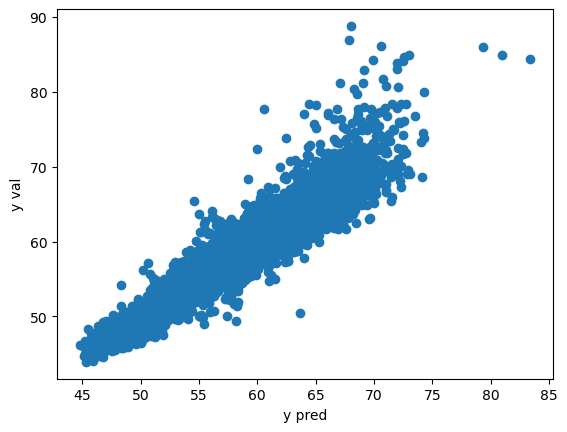

In [61]:
plt.scatter(val_preds, y_val["lceq"])
plt.xlabel("y pred")
plt.ylabel("y val")

In [62]:
r2_score(val_preds, y_val["lceq"])

0.9074528455168079

In [63]:
## save model

import pickle

pickle.dump(xgb, open("../model/model_noise_level_file42/xgb_lceq.pkl", "wb"))

## Predict lcpeak

In [ ]:
# Define the model parameters
model_params = {
    "random_forest": {
        "model": RandomForestRegressor(),
        "params": {
            "n_estimators": randint(50, 100),
            "max_depth": randint(3, 50),
            "max_features": ["auto", "sqrt"],
            "min_samples_split": randint(2, 20),
            "min_samples_leaf": randint(1, 10),
            "bootstrap": [True, False],
        },
    },
    "gradient_boosting": {
        "model": GradientBoostingRegressor(),
        "params": {
            "n_estimators": randint(50, 100),
            "learning_rate": uniform(0.01, 0.5),
            "max_depth": randint(1, 10),
            "min_samples_split": randint(2, 20),
            "min_samples_leaf": randint(1, 10),
        },
    },
    "xgboost": {
        "model": xgboost.XGBRegressor(),
        "params": {
            "n_estimators": randint(50, 100),
            "learning_rate": uniform(0.01, 0.5),
            "max_depth": randint(1, 10),
            "min_child_weight": randint(1, 10),
            "gamma": uniform(0, 1),
            "reg_alpha": uniform(0, 1),
            "reg_lambda": uniform(0, 1),
        },
    },
}

params_dict = {}

# Loop through each model in model_params and run RandomizedSearchCV
for model_name, model_info in model_params.items():
    print("Running RandomizedSearchCV for {}...".format(model_name))

    # Create a RandomizedSearchCV object for the current model
    model = model_info["model"]
    param_dist = model_info["params"]
    random_search = RandomizedSearchCV(
        model, param_distributions=param_dist, n_iter=10, cv=5, n_jobs=1, random_state=7
    )

    # Fit the RandomizedSearchCV object to the data
    random_search.fit(X_train, y_train["lcpeak"])

    # Print the best parameters and score
    params_dict[model_name] = random_search.best_params_
    print("Best parameters for {}: ".format(model_name), random_search.best_params_)
    print("Best score for {}: ".format(model_name), random_search.best_score_)
    print("\n")

In [ ]:
# Save optimal param dictionary
pickle.dump(params_dict, open("../model/model_noise_level_file42/lcpeak_dict", "wb"))

In [64]:
# Load param dictionary
lcpeak_dict = pickle.load(open("../model/model_noise_level_file42/lcpeak_dict", "rb"))
lcpeak_dict

{'random_forest': {'bootstrap': False,
  'max_depth': 31,
  'max_features': 'sqrt',
  'min_samples_leaf': 1,
  'min_samples_split': 6,
  'n_estimators': 85},
 'gradient_boosting': {'learning_rate': 0.4289589971546303,
  'max_depth': 8,
  'min_samples_leaf': 8,
  'min_samples_split': 2,
  'n_estimators': 71},
 'xgboost': {'gamma': 0.13316944575925016,
  'learning_rate': 0.2717062903368829,
  'max_depth': 9,
  'min_child_weight': 4,
  'n_estimators': 98,
  'reg_alpha': 0.19335562339240953,
  'reg_lambda': 0.100473971701034}}

In [65]:
gb_params = lcpeak_dict["gradient_boosting"]

gb = GradientBoostingRegressor(**gb_params, random_state=7)

gb.fit(X_train, y_train["lcpeak"])

train_preds = gb.predict(X_train)
val_preds = gb.predict(X_val)

print("Train RMSE:", np.sqrt(mean_squared_error(train_preds, y_train["lcpeak"])))
print("Val RMSE:", np.sqrt(mean_squared_error(val_preds, y_val["lcpeak"])))
print("Train MAE:", mean_absolute_error(train_preds, y_train["lcpeak"]))
print("Val MAE:", mean_absolute_error(val_preds, y_val["lcpeak"]))

Train RMSE: 1.2281198657500612
Val RMSE: 1.7569921462489921
Train MAE: 0.8588264771216795
Val MAE: 1.1805057522253848


In [66]:
rf_params = lcpeak_dict["random_forest"]

rf = RandomForestRegressor(**rf_params, random_state=7)

rf.fit(X_train, y_train["lcpeak"])

train_preds = rf.predict(X_train)
val_preds = rf.predict(X_val)

print("Train RMSE:", np.sqrt(mean_squared_error(train_preds, y_train["lcpeak"])))
print("Val RMSE:", np.sqrt(mean_squared_error(val_preds, y_val["lcpeak"])))
print("Train MAE:", mean_absolute_error(train_preds, y_train["lcpeak"]))
print("Val MAE:", mean_absolute_error(val_preds, y_val["lcpeak"]))

Train RMSE: 0.9659273783157202
Val RMSE: 1.8517733426245717
Train MAE: 0.6464785007176574
Val MAE: 1.25212618740849


In [67]:
import xgboost

xgb_params = lcpeak_dict["xgboost"]

xgb = xgboost.XGBRegressor(**xgb_params, random_state=7)

xgb.fit(X_train, y_train["lcpeak"])

train_preds = xgb.predict(X_train)
val_preds = xgb.predict(X_val)


print("Train RMSE:", np.sqrt(mean_squared_error(train_preds, y_train["lcpeak"])))
print("Val RMSE:", np.sqrt(mean_squared_error(val_preds, y_val["lcpeak"])))
print("Train MAE:", mean_absolute_error(train_preds, y_train["lcpeak"]))
print("Val MAE:", mean_absolute_error(val_preds, y_val["lcpeak"]))

Train RMSE: 0.9276570802985057
Val RMSE: 1.5889109872385543
Train MAE: 0.6519813332222163
Val MAE: 1.0586098749995325


Text(0, 0.5, 'y val')

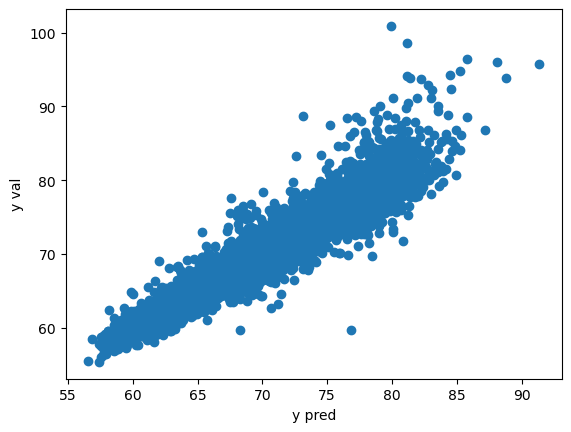

In [68]:
plt.scatter(val_preds, y_val["lcpeak"])
plt.xlabel("y pred")
plt.ylabel("y val")

In [69]:
r2_score(val_preds, y_val["lcpeak"])

0.906577081950336

In [70]:
## save model

pickle.dump(xgb, open("../model/model_noise_level_file42/xgb_lcpeak.pkl", "wb"))

## In this section, we would predict lcpeak using data in file meteo


In [86]:
def merge_csv_files(directory_path,file_list,delim=";"):
    """
    Merges all CSV files in a directory into a single pandas DataFrame.

    Args:
    directory_path (str): The directory path containing the CSV files.
    delim (str): character used for delimiter in CSV files
    file_list = list of strings of individual file names

    Returns:
    merged_df (pandas.DataFrame): The merged pandas DataFrame of all CSV files in the directory.
    """
    dfs = []

    # loop through each file in the directory
    for file in file_list:
        # check if the file is a CSV file
        if file.endswith(".csv"):
            file_path = directory_path + file
            df = pd.read_csv(file_path, delimiter=delim)
            dfs.append(df)

    # concatenate all dataframes
    merged_df = pd.concat(dfs, ignore_index=True)

    return merged_df

In [87]:
# Meteo data
folder_path = "s3://teamchadmda"
file_list_meteo = ["LC_2022Q1.csv","LC_2022Q2.csv","LC_2022Q3.csv","LC_2022Q4.csv",]

# lots of files, takes a while
meteo = merge_csv_files(folder_path + "/meteodata/",file_list_meteo,delim=',')

In [88]:
meteo['date'] = pd.to_datetime(meteo['DATEUTC']).dt.date

In [89]:
meteo = meteo[~meteo.LC_HUMIDITY.isnull()]

In [90]:
meteo.isna().mean()

DATEUTC         0.000000
ID              0.000000
LC_HUMIDITY     0.000000
LC_DWPTEMP      0.000000
LC_n            0.000000
LC_RAD          0.000000
LC_RAININ       0.000000
LC_DAILYRAIN    0.000000
LC_WINDDIR      0.000000
LC_WINDSPEED    0.000000
Date            0.000000
Year            0.000000
Month           0.000000
Day             0.000000
Hour            0.000000
Minute          0.000000
LC_RAD60        0.000000
LC_TEMP_QCL0    0.000000
LC_TEMP_QCL1    0.005846
LC_TEMP_QCL2    0.005846
LC_TEMP_QCL3    0.005846
date            0.000000
dtype: float64

In [91]:
meteo = meteo.groupby(["date","Month", "Hour"]).mean().reset_index()

C:\Users\jef-w\AppData\Local\Temp\ipykernel_3008\1635437679.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  meteo = meteo.groupby(["date","Month", "Hour"]).mean().reset_index()


In [92]:
meteo.shape

(8761, 19)

In [93]:
meteo.drop(["Year", "Day", "Minute"], axis = 1, inplace = True)

In [94]:
meteo.rename(columns={'Month': 'month',
                      'Hour': 'hour'}, inplace = True)

In [95]:
data_model_meteo = file42.merge(meteo, how="inner",
                                left_on = ["date", "hour", "month"],
                                right_on = ["date", "hour", "month"])

In [96]:
data_model_meteo.head(3)

,object_id,date,hour,month,weekday,lamax,laeq,lceq,lcpeak,LC_HUMIDITY,...,LC_RAD,LC_RAININ,LC_DAILYRAIN,LC_WINDDIR,LC_WINDSPEED,LC_RAD60,LC_TEMP_QCL0,LC_TEMP_QCL1,LC_TEMP_QCL2,LC_TEMP_QCL3
0,255439,2022-02-28,8,2,Mon,58.679893,56.965367,67.359289,78.976896,68.511797,...,46.6951,0.000005,0.000011,18.411978,0.118076,31.76225,2.536298,2.543836,2.531809,2.428479
1,255441,2022-02-28,8,2,Mon,55.492778,54.066667,65.229694,76.438689,68.511797,...,46.6951,0.000005,0.000011,18.411978,0.118076,31.76225,2.536298,2.543836,2.531809,2.428479
2,255442,2022-02-28,8,2,Mon,55.842472,54.106667,63.679853,75.430328,68.511797,...,46.6951,0.000005,0.000011,18.411978,0.118076,31.76225,2.536298,2.543836,2.531809,2.428479


In [97]:
data_model_meteo.shape

(55469, 22)

In [98]:
## split train, test data
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(data_model_meteo, test_size=0.2, random_state = 7)

In [99]:
target_variable = ["lamax", "laeq", "lceq", "lcpeak"]


In [100]:
X_train = train_df.drop(target_variable + ["date"], axis = 1)
X_val = val_df.drop(target_variable + ["date"], axis = 1)

In [101]:
X_train.columns

Index(['object_id', 'hour', 'month', 'weekday', 'LC_HUMIDITY', 'LC_DWPTEMP',
       'LC_n', 'LC_RAD', 'LC_RAININ', 'LC_DAILYRAIN', 'LC_WINDDIR',
       'LC_WINDSPEED', 'LC_RAD60', 'LC_TEMP_QCL0', 'LC_TEMP_QCL1',
       'LC_TEMP_QCL2', 'LC_TEMP_QCL3'],
      dtype='object')

In [102]:
X_train.dtypes

object_id         int64
hour              int64
month             int64
weekday          object
LC_HUMIDITY     float64
LC_DWPTEMP      float64
LC_n            float64
LC_RAD          float64
LC_RAININ       float64
LC_DAILYRAIN    float64
LC_WINDDIR      float64
LC_WINDSPEED    float64
LC_RAD60        float64
LC_TEMP_QCL0    float64
LC_TEMP_QCL1    float64
LC_TEMP_QCL2    float64
LC_TEMP_QCL3    float64
dtype: object

In [103]:
y_train = train_df[target_variable]
y_val = val_df[target_variable]

In [104]:
one_hot_var = ['object_id', "hour", "month", "weekday"]
numerical_var = [col for col in X_train.columns if col not in one_hot_var]

In [105]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
t = ColumnTransformer(
    transformers = [
        ('OneHot', OneHotEncoder(handle_unknown='ignore'), one_hot_var),
        ('StandardScaler', StandardScaler(), numerical_var)
        
    ])

# fit the encoder
t.fit(X_train)

ColumnTransformer(transformers=[('OneHot',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['object_id', 'hour', 'month', 'weekday']),
                                ('StandardScaler', StandardScaler(),
                                 ['LC_HUMIDITY', 'LC_DWPTEMP', 'LC_n', 'LC_RAD',
                                  'LC_RAININ', 'LC_DAILYRAIN', 'LC_WINDDIR',
                                  'LC_WINDSPEED', 'LC_RAD60', 'LC_TEMP_QCL0',
                                  'LC_TEMP_QCL1', 'LC_TEMP_QCL2',
                                  'LC_TEMP_QCL3'])])

In [106]:
## save columnstransformer

with open("../model/model_noise_level_file42/encoder_model_file42_meteo.pkl", 'wb') as file:
    pickle.dump(t, file)

In [107]:
# create pandas DataFrame from sparse matrix

from scipy.sparse import csr_matrix

X_train = pd.DataFrame.sparse.from_spmatrix(csr_matrix(t.fit_transform(X_train)))
X_train.columns  = t.get_feature_names_out()

X_val = pd.DataFrame.sparse.from_spmatrix(csr_matrix(t.fit_transform(X_val)))
X_val.columns  = t.get_feature_names_out()


In [108]:
X_train.columns

Index(['OneHot__object_id_255439', 'OneHot__object_id_255440',
       'OneHot__object_id_255441', 'OneHot__object_id_255442',
       'OneHot__object_id_255443', 'OneHot__object_id_255444',
       'OneHot__object_id_280324', 'OneHot__object_id_303910',
       'OneHot__hour_0', 'OneHot__hour_1', 'OneHot__hour_2', 'OneHot__hour_3',
       'OneHot__hour_4', 'OneHot__hour_5', 'OneHot__hour_6', 'OneHot__hour_7',
       'OneHot__hour_8', 'OneHot__hour_9', 'OneHot__hour_10',
       'OneHot__hour_11', 'OneHot__hour_12', 'OneHot__hour_13',
       'OneHot__hour_14', 'OneHot__hour_15', 'OneHot__hour_16',
       'OneHot__hour_17', 'OneHot__hour_18', 'OneHot__hour_19',
       'OneHot__hour_20', 'OneHot__hour_21', 'OneHot__hour_22',
       'OneHot__hour_23', 'OneHot__month_1', 'OneHot__month_2',
       'OneHot__month_3', 'OneHot__month_4', 'OneHot__month_5',
       'OneHot__month_6', 'OneHot__month_7', 'OneHot__month_8',
       'OneHot__month_9', 'OneHot__month_10', 'OneHot__month_11',
       'OneHot

In [ ]:
# Define the model parameters
model_params = {
    'random_forest': {
        'model': RandomForestRegressor(),
        'params': {
            'n_estimators': randint(50, 100),
            'max_depth': randint(3, 50),
            'max_features': ['auto', 'sqrt'],
            'min_samples_split': randint(2, 20),
            'min_samples_leaf': randint(1, 10),
            'bootstrap': [True, False]
        }
    },
    'gradient_boosting': {
        'model': GradientBoostingRegressor(),
        'params': {
            'n_estimators': randint(50, 100),
            'learning_rate': uniform(0.01, 0.5),
            'max_depth': randint(1, 10),
            'min_samples_split': randint(2, 20),
            'min_samples_leaf': randint(1, 10)
        }
    },
    
    'xgboost': {
        'model': xgboost.XGBRegressor(),
        'params': {
            'n_estimators': randint(50, 100),
            'learning_rate': uniform(0.01, 0.5),
            'max_depth': randint(1, 10),
            'min_child_weight': randint(1, 10),
            'gamma': uniform(0, 1),
            'reg_alpha': uniform(0, 1),
            'reg_lambda': uniform(0, 1),
        }
    }
    
}

params_dict = {}

# Loop through each model in model_params and run RandomizedSearchCV
for model_name, model_info in model_params.items():
    print("Running RandomizedSearchCV for {}...".format(model_name))
    
    # Create a RandomizedSearchCV object for the current model
    model = model_info['model']
    param_dist = model_info['params']
    random_search = RandomizedSearchCV(model, param_distributions=param_dist,
                                       n_iter=10, cv=5, n_jobs=1, random_state=7)
    
    # Fit the RandomizedSearchCV object to the data
    random_search.fit(X_train, y_train['lcpeak'])
    
    # Print the best parameters and score
    params_dict[model_name] = random_search.best_params_
    print("Best parameters for {}: ".format(model_name), random_search.best_params_)
    print("Best score for {}: ".format(model_name), random_search.best_score_)
    print("\n")

In [ ]:
# Save optimal param dictionary
pickle.dump(params_dict, open("../model/model_noise_level_file42/lcpeak_dict_meteo", "wb"))

In [109]:
# Load param dictionary
lcpeak_dict_meteo = pickle.load(open("../model/model_noise_level_file42/lcpeak_dict_meteo", "rb"))
lcpeak_dict_meteo

{'random_forest': {'bootstrap': False,
  'max_depth': 31,
  'max_features': 'sqrt',
  'min_samples_leaf': 1,
  'min_samples_split': 6,
  'n_estimators': 85},
 'gradient_boosting': {'learning_rate': 0.4289589971546303,
  'max_depth': 8,
  'min_samples_leaf': 8,
  'min_samples_split': 2,
  'n_estimators': 71},
 'xgboost': {'gamma': 0.13316944575925016,
  'learning_rate': 0.2717062903368829,
  'max_depth': 9,
  'min_child_weight': 4,
  'n_estimators': 98,
  'reg_alpha': 0.19335562339240953,
  'reg_lambda': 0.100473971701034}}

In [110]:
gb_params = lcpeak_dict_meteo["gradient_boosting"]

gb = GradientBoostingRegressor(**gb_params, random_state=7)

gb.fit(X_train, y_train["lcpeak"])

train_preds = gb.predict(X_train)
val_preds = gb.predict(X_val)

print("Train RMSE:", np.sqrt(mean_squared_error(train_preds, y_train["lcpeak"])))
print("Val RMSE:", np.sqrt(mean_squared_error(val_preds, y_val["lcpeak"])))
print("Train MAE:", mean_absolute_error(train_preds, y_train["lcpeak"]))
print("Val MAE:", mean_absolute_error(val_preds, y_val["lcpeak"]))

Train RMSE: 1.3256049999183057
Val RMSE: 2.3388216954880083
Train MAE: 0.918873780790303
Val MAE: 1.6316743094156712


In [111]:
rf_params = lcpeak_dict_meteo["random_forest"]

rf = RandomForestRegressor(**rf_params, random_state=7)

rf.fit(X_train, y_train["lcpeak"])

train_preds = rf.predict(X_train)
val_preds = rf.predict(X_val)

print("Train RMSE:", np.sqrt(mean_squared_error(train_preds, y_train["lcpeak"])))
print("Val RMSE:", np.sqrt(mean_squared_error(val_preds, y_val["lcpeak"])))
print("Train MAE:", mean_absolute_error(train_preds, y_train["lcpeak"]))
print("Val MAE:", mean_absolute_error(val_preds, y_val["lcpeak"]))

Train RMSE: 0.8819050810699819
Val RMSE: 2.2757907740097716
Train MAE: 0.5826451482370608
Val MAE: 1.5624158950712714


In [112]:
import xgboost

xgb_params = lcpeak_dict_meteo["xgboost"]

xgb = xgboost.XGBRegressor(**xgb_params, random_state=7)

xgb.fit(X_train, y_train["lcpeak"])

train_preds = xgb.predict(X_train)
val_preds = xgb.predict(X_val)


print("Train RMSE:", np.sqrt(mean_squared_error(train_preds, y_train["lcpeak"])))
print("Val RMSE:", np.sqrt(mean_squared_error(val_preds, y_val["lcpeak"])))
print("Train MAE:", mean_absolute_error(train_preds, y_train["lcpeak"]))
print("Val MAE:", mean_absolute_error(val_preds, y_val["lcpeak"]))

Train RMSE: 1.1126898339349605
Val RMSE: 2.2474710779172913
Train MAE: 0.7719166703783709
Val MAE: 1.6200955616113704


Text(0, 0.5, 'y val')

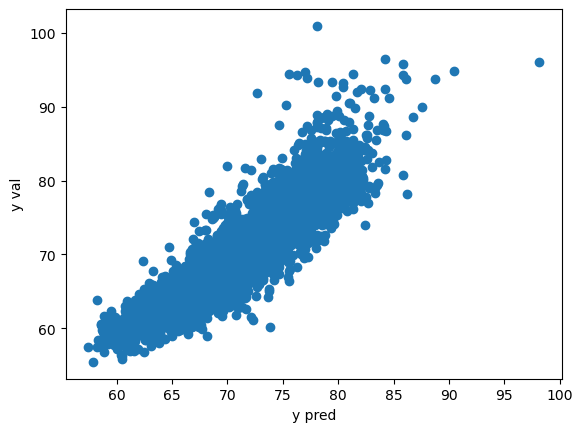

In [113]:
plt.scatter(val_preds, y_val["lcpeak"])
plt.xlabel("y pred")
plt.ylabel("y val")

In [114]:
r2_score(val_preds, y_val["lcpeak"])

0.7729109805718346

In [115]:
## save model

pickle.dump(xgb, open("../model/model_noise_level_file42/xgb_lcpeak_meteo.pkl", "wb"))